## ptCLM_multi
#### Plots simulated soil temperature and  water state for multiple sites
- Will Wieder
- Created Oct 2020

In [1]:
import xarray as xr
import cf_units as cf
import numpy as np
import pandas as pd
from ctsm_py import utils
from scipy import signal,stats

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.dates as mdates

# supress Runtime warnings that let you know when code isn't too efficiently
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

%matplotlib inline

### Point to files
* All sims use newPHS parameterization and low SLA (0.01 m2/gC)
* FF and DM also have sandier sols and higher leaf CN (32 vs 24).

In [2]:
# Niwot LTER  simulations
years = range(2015,2019)
nmon  = 12
rollHour = -12  

longSite  =  ['fell_field','dry_meadow','moist_meadow','snowbed']
veg  = ['ff','dm','mm','sb']
site = [veg[v]+'_newPHS_lowSLA' for v in range(len(veg)) ]
site[0] = site[0]+'_SAND_cn32'
site[1] = site[1]+'_SAND_cn32'
print(site)
case  = ['clm50bgc_NWT_'+site[v] for v in range(len(veg)) ]

OBSdir = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/'
OBSdir = [OBSdir +longSite[v]+'/' for v in range(len(veg)) ]
OUTdir = OBSdir

# Points to simulation files
CLMdir = ['/glade/scratch/wwieder/archive/'+case[v]+'/lnd/hist/' 
      for  v in range(len(veg)) ]
CLMfile = [[]] *len(veg)
CLMmon  = [[]] *len(veg)
for v in range(len(veg)):
    # each h1 file
    CLMfile[v] = [CLMdir[v] + case[v] +'.clm2.h1.'+str(years[i]) +'-01-01-00000.nc' 
                  for i in range(len(years)) ]  
    # single month of data for soil C pools 
    CLMmon[v] = [CLMdir[v] + case[v] +'.clm2.h0.'+str(years[0])+'-01.nc'] 

CLMfile[0][0]

['ff_newPHS_lowSLA_SAND_cn32', 'dm_newPHS_lowSLA_SAND_cn32', 'mm_newPHS_lowSLA', 'sb_newPHS_lowSLA']


'/glade/scratch/wwieder/archive/clm50bgc_NWT_ff_newPHS_lowSLA_SAND_cn32/lnd/hist/clm50bgc_NWT_ff_newPHS_lowSLA_SAND_cn32.clm2.h1.2015-01-01-00000.nc'

### Read in dataset 
- combine along new dimension `vegdim`
- get rid of extra `lndgrid` dimension
- remove CLM time shift

In [3]:
dsCLM = [xr.open_mfdataset(CLMfile[v], decode_times=True, combine='by_coords') for v in range(len(veg)) ]
vegdim = xr.DataArray(longSite, dims='veg', name='veg') 
dsCLM = xr.concat(dsCLM, dim=vegdim)
dsCLM = dsCLM.isel(lndgrid=0)
dsCLM = dsCLM.shift(time=-1)
print('---- read  in data  ----')
dsCLM

---- read  in data  ----


<xarray.Dataset>
Dimensions:       (hist_interval: 2, levdcmp: 25, levgrnd: 25, levlak: 10, levsoi: 20, time: 70080, veg: 4)
Coordinates:
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 ... 28.870724 41.998436
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.325 44.775
  * time          (time) object 2015-01-01 00:00:00 ... 2018-12-31 23:30:07
  * levdcmp       (levdcmp) float32 0.01 0.04 0.09 ... 28.870724 41.998436
  * veg           (veg) <U12 'fell_field' 'dry_meadow' 'moist_meadow' 'snowbed'
Dimensions without coordinates: hist_interval, levsoi
Data variables:
    mcdate        (veg, time) float64 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    mcsec         (veg, time) float64 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    mdcur         (veg, time) float64 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    mscur         (veg, time) float64 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    nstep         (veg, time) float64 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    time_bounds   (veg, time, hist_interval) object dask.array<chunksize=(1, 17520, 2), meta=np.ndarray>
    date_written  (veg, time) object dask.array<chunksize=(1, 17520), meta=np.ndarray>
    time_written  (veg, time) object dask.array<chunksize=(1, 17520), meta=np.ndarray>
    lon           (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    lat           (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    area          (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    landfrac      (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    landmask      (veg, time) float64 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    pftmask       (veg, time) float64 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    nbedrock      (veg, time) float64 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    AGNPP         (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    AR            (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    BGNPP         (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    BTRAN2        (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    COSZEN        (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    EFLX_LH_TOT   (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    ELAI          (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    FCEV          (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    FCTR          (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    FGEV          (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    FGR           (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    FGR12         (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    FIRA          (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    FIRE          (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    FLDS          (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    FPI           (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    FPSN          (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    FSA           (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    FSDS          (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    FSH           (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    FSH_G         (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    FSM           (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    FSR           (veg, time) float32 dask.array<chunksize=(1, 17520), meta=np.ndarray>
    GPP           (veg, time) float32 dask.arra

In [4]:
#dsCLM.levgrnd

In [5]:
# create new variables to subset data
dsCLM['year']  = dsCLM['time.year']
dsCLM['month']  = dsCLM['time.month']
dsCLM['season'] = dsCLM['time.season']

#Can't groupby hour & minutes, so combine them here
dsCLM['HourMin'] = np.round(dsCLM['time.hour'] + dsCLM['time.minute']/60,1)
dsCLM['MonDay'] = np.round(dsCLM['time.month'] + dsCLM['time.day']/100,2)

#  total preciptiation
dsCLM['ppt'] = dsCLM.RAIN + dsCLM.SNOW
dsCLM['ppt'].attrs['units'] = dsCLM.RAIN.attrs['units']
dsCLM['ppt'].attrs['long_name'] = 'RAIN + SNOW'

## Read in observatons 

In [6]:
nwtOBS = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/NWT_lter_obs_downloads/'
dsNET = pd.read_table(nwtOBS+'sensor_network_soil_data_30_min.txt')#.to_xarray()  # Saddle sensors
dsTVan = pd.read_table(nwtOBS+'tvan_soil_data_30_min.txt') # Tvan soil sensors
dsSNO = nwtOBS+'saddle_grid_snow_depth_data_biweekly.txt' # Saddle snow 
dsNPP = nwtOBS+'saddle_grid_productivity_data.txt'    # Saddle productivity
dsNET.date = pd.to_datetime(dsNET.date)
dsTVan.date = pd.to_datetime(dsTVan.date)
#dsTVan.insert(0, 'veg_com', 'ff')
dsSOI = pd.concat([dsNET,dsTVan]) 

In [7]:
dsSOIgroup = dsSOI.groupby(['date','veg_com'])
dsSOIgroup

In [8]:
dsSOIdaily = dsSOIgroup.aggregate(np.mean)
dsSOIdailySTD = dsSOIgroup.aggregate(np.std)
#dsSOIdaily
#dsSOIdaily.groupby(['veg_com'])['soiltemp_upper_avg'].plot(x='date',by='veg_com',legend=True);
#dsTVandaily['soiltemp_upper_avg'].plot();
#dsNETdaily['soiltemp_upper_avg']['mean']

### Convert Saddle network data to xarray

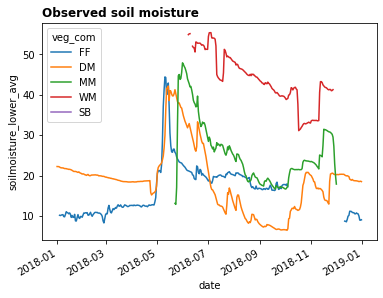

In [9]:
dsSOI = dsSOIdaily.to_xarray()
dsSOIstd = dsSOIdailySTD.to_xarray()
Veg = ["FF", "DM", "MM",'WM','SB']
fullVeg = ["fell_field", "dry_meadow", "moist_meadow",'wet_meadow','snowbed']
dsSOI = dsSOI.reindex({'veg_com': Veg})
dsSOIstd = dsSOIstd.reindex({'veg_com': Veg})
dsCLM = dsCLM.reindex({'veg': fullVeg})
# Quick look at data
dsSOI.where(dsSOI['date.year']==2018).soilmoisture_lower_avg.plot(hue='veg_com');
plt.title('Observed soil moisture', loc='left', fontsize='large', fontweight='bold');

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


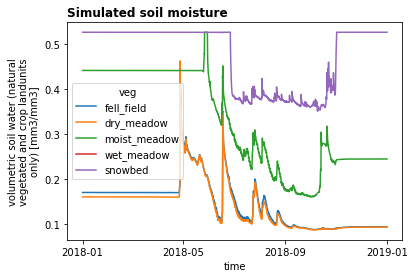

In [10]:
dsCLM.where(dsCLM['year']>2017).H2OSOI.isel(levsoi=2).plot.line(hue='veg');
plt.title('Simulated soil moisture', loc='left', fontsize='large', fontweight='bold');

--------------------------
## comparison plots
--------------------------

<xarray.DataArray 'GPP' (veg: 5, year: 4)>
dask.array<mul, shape=(5, 4), dtype=float32, chunksize=(2, 1)>
Coordinates:
  * veg      (veg) object 'fell_field' 'dry_meadow' ... 'wet_meadow' 'snowbed'
  * year     (year) int64 2015 2016 2017 2018


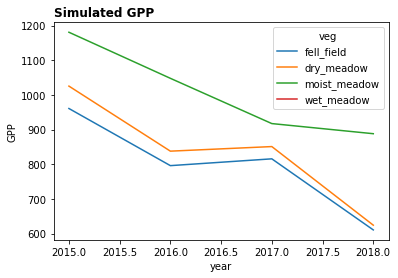

In [11]:
annPPT = dsCLM['ppt'].groupby(dsCLM['year']).mean()
annPPT = annPPT * 3600 * 24 * 365 / 10  #convert mm/s to cm/y
#print(annPPT)

annGPP = dsCLM['GPP'].groupby(dsCLM['year']).mean()
annGPP = annGPP * 3600 * 24 * 365   #convert gC/m2/s to annual
print(annGPP)
annGPP.isel(veg=range(len(veg))).plot.line(x='year');
plt.title('Simulated GPP', loc='left', fontsize='large', fontweight='bold');

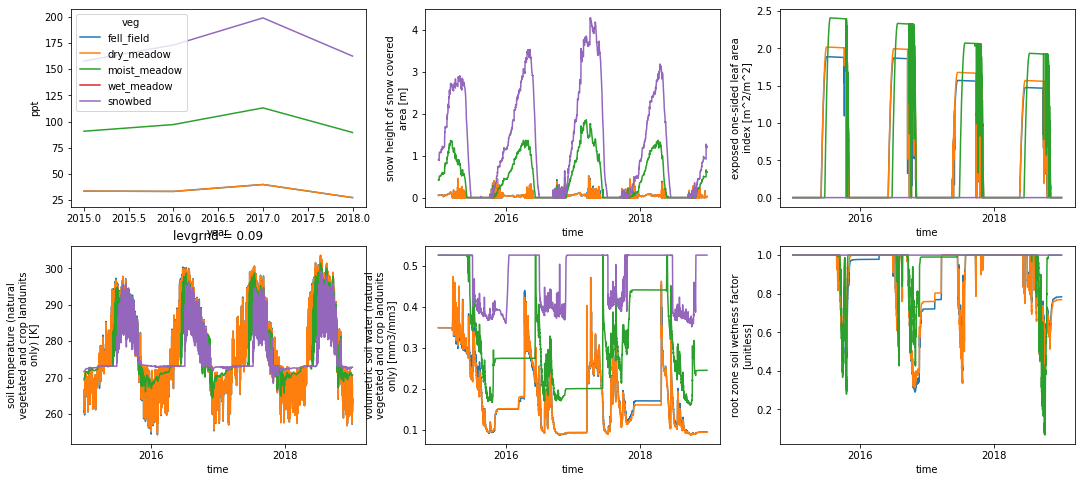

In [12]:
plotVars = ['ppt','SNOW_DEPTH','ELAI','TSOI','H2OSOI','BTRAN2']
plt.figure(figsize=[18,8])

plt.subplot(231)
annPPT.plot.line(x='year', hue="veg",add_legend=True)
plt.subplot(232)
dsCLM[plotVars[1]].plot.line(x='time', hue="veg",add_legend=False)
plt.subplot(233)
dsCLM[plotVars[2]].plot.line(x='time', hue="veg",add_legend=False);
plt.subplot(234)
dsCLM[plotVars[3]].isel(levgrnd=2).plot.line(x='time', hue="veg",add_legend=False);
plt.subplot(235)
dsCLM[plotVars[4]].isel(levsoi=2).plot.line(x='time', hue="veg",add_legend=False);
plt.subplot(236)
dsCLM[plotVars[5]].plot.line(x='time', hue="veg",add_legend=False);


In [13]:
dsCLM["levgrnd"].isel(levgrnd=slice(0,20)).values

array([0.01, 0.04, 0.09, 0.16, 0.26, 0.4 , 0.58, 0.8 , 1.06, 1.36, 1.7 ,
       2.08, 2.5 , 2.99, 3.58, 4.27, 5.06, 5.95, 6.94, 8.03],
      dtype=float32)

### Plots of depth resolved temperature and moisture

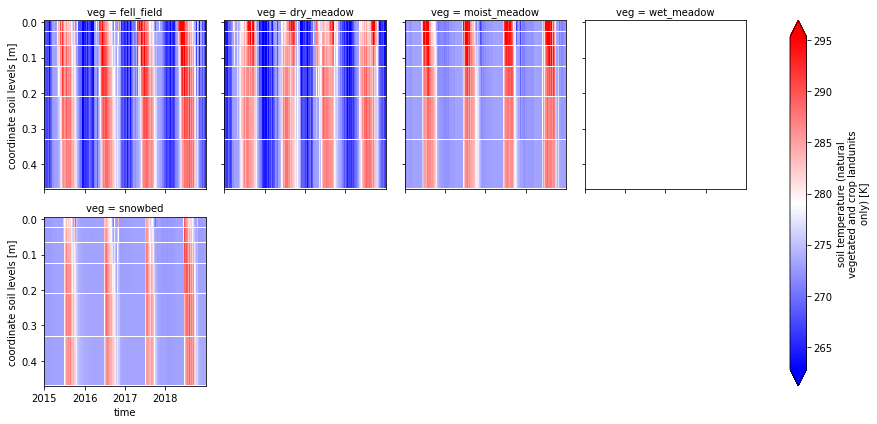

In [14]:
simple = dsCLM.TSOI.isel(levgrnd=(slice(0,6))).plot(x="time",yincrease=False, robust=True, col='veg', col_wrap=5,cmap='bwr'); 

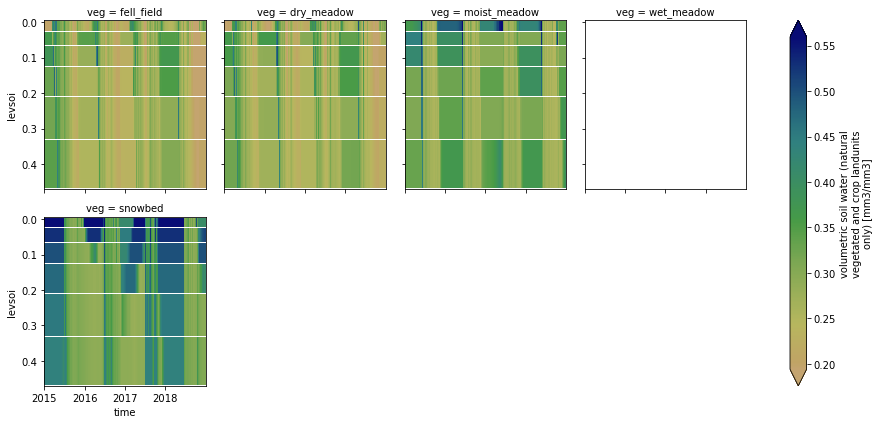

In [15]:
################### Function to truncate color map ###################
def truncate_colormap(cmapIn='jet', minval=0.0, maxval=1.0, n=100):
    '''truncate_colormap(cmapIn='jet', minval=0.0, maxval=1.0, n=100)'''    
    cmapIn = plt.get_cmap(cmapIn)

    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmapIn.name, a=minval, b=maxval),
        cmapIn(np.linspace(minval, maxval, n)))

    arr = np.linspace(0, 50, 100).reshape((10, 10))
    #fig, ax = plt.subplots(ncols=2)
    #ax[0].imshow(arr, interpolation='nearest', cmap=cmapIn)
    #ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
    #plt.show()

    return new_cmap

cmap_mod = truncate_colormap(cmapIn='gist_earth_r',minval=.2, maxval=0.95)  # calls function to truncate colormap

temp = dsCLM['H2OSOI'].copy(deep=True)
temp = temp.assign_coords({"levsoi": dsCLM["levgrnd"].isel(levgrnd=slice(0,20)).values})
simple = temp.isel(levsoi=(slice(0,6))).plot(
    x="time",yincrease=False, robust=True, col='veg', col_wrap=5,cmap=cmap_mod);

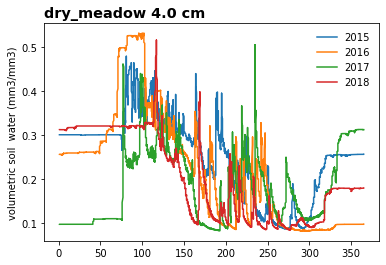

In [14]:
nyear = len(years) 
nlev = 1
nveg = 1
for i in range(nyear):
    x = dsCLM['time.dayofyear'].where(dsCLM['year']==years[i])
    y = dsCLM.H2OSOI.isel(levsoi=nlev,veg=nveg).where(dsCLM['year']==years[i])
    plt.plot(x, y, '-')
depth = str(np.round(dsCLM["levgrnd"].isel(levgrnd=nlev).values * 100,0)) 
plt.legend(years, frameon=False, loc='upper right');
plt.title(longSite[nveg]+ " " +depth + " cm", loc='left', fontsize='x-large', fontweight='bold')
plt.ylabel('volumetric soil  water (mm3/mm3)');

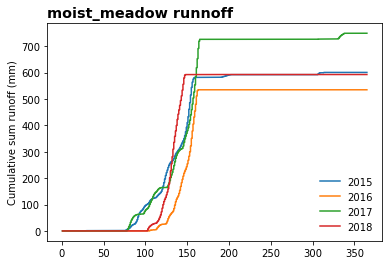

In [16]:
nyear = len(years) 
nveg =2
for i in range(nyear):
    x = dsCLM['time.dayofyear'].where(dsCLM['year']==years[i])
    y = dsCLM.QRUNOFF.isel(veg=nveg).where(dsCLM['year']==years[i])
    y = y.cumsum(dim='time')*30*60 #convert mm/s flux to mm water
    plt.plot(x, y, '-')
plt.legend(years, frameon=False, loc='lower right');
plt.title(longSite[nveg]+ " runnoff", loc='left', fontsize='x-large', fontweight='bold')
plt.ylabel('Cumulative sum runoff (mm)');

{'long_name': 'snow height of snow covered area',
 'units': 'm',
 'cell_methods': 'time: mean'}

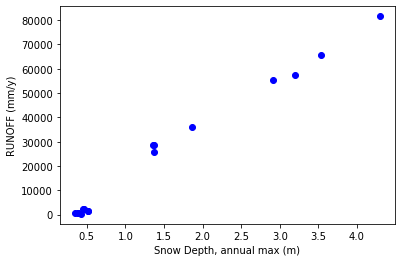

In [17]:
x = dsCLM.SNOW_DEPTH.groupby(dsCLM['year']).max()
y = dsCLM.QRUNOFF.groupby(dsCLM['year']).sum() * 24*3600
plt.plot(x, y, 'o', color='b');
plt.xlabel('Snow Depth, annual max (m)');
plt.ylabel('RUNOFF (mm/y)');
dsCLM.SNOW_DEPTH.attrs

### plot soil moisture and temperature for single year

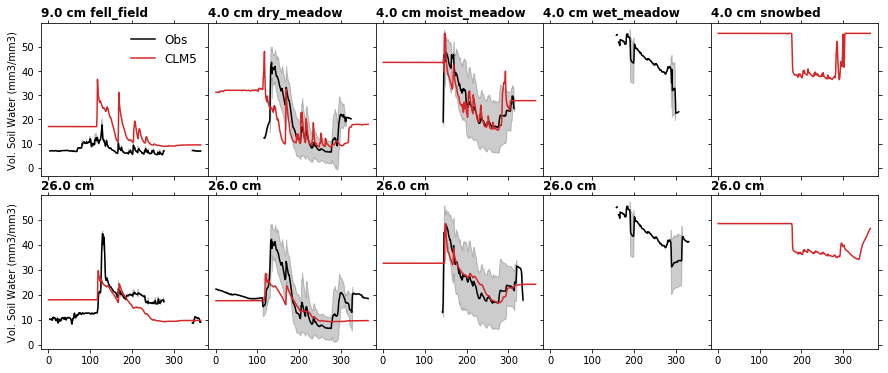

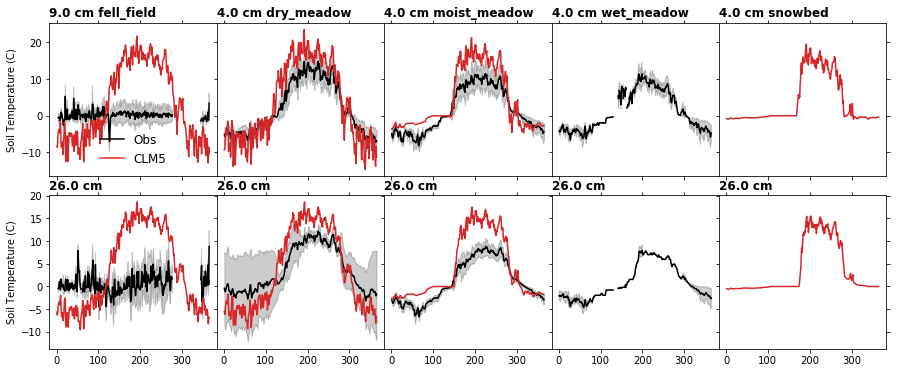

In [18]:
nyear = len(years) 
clmVARS = ['H2OSOI','TSOI']
obsVARSu = ['soilmoisture_upper_avg','soiltemp_upper_avg']
obsVARSl = ['soilmoisture_lower_avg','soiltemp_lower_avg']

for v in range(len(clmVARS)):
    fig, axs = plt.subplots(2, len(Veg), 
                        sharey='row', sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0.12},
                        figsize=(15,6))    
    for i in range(len(Veg)):
        for j in range(2):
            if i == 0: 
                nlev = 2 #10 cm for fell field
                plotYear =  2018
            else: 
                nlev = 1 # 5 cm for sensor network
                plotYear =  2018
            if j == 1: nlev = 4

            # Srelect data to plot    
            x = dsCLM['time.dayofyear'].where(dsCLM['year']==plotYear)
            x2 = dsSOI['date.dayofyear'].where(dsSOI['date.year']==plotYear)

            if v == 0:
                y = dsCLM[clmVARS[v]].isel(levsoi=nlev,veg=i).where(dsCLM['year']==plotYear).groupby(x).mean() * 100
            else:
                y = dsCLM[clmVARS[v]].isel(levgrnd=nlev,veg=i).where(dsCLM['year']==plotYear).groupby(x).mean() -273.15
            
            if j == 0: 
                y2 = dsSOI[obsVARSu[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear)
                ySTD = dsSOIstd[obsVARSu[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear)
            if j == 1: 
                y2 = dsSOI[obsVARSl[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear)
                ySTD = dsSOIstd[obsVARSl[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear)
            x = x.groupby(x).mean()
            
            axs[j,i].plot(x2, y2, '-', color='k')
            axs[j,i].plot(x, y, '-',color='tab:red')
            axs[j,i].fill_between(x2, y2-ySTD, y2+ySTD, alpha=0.2,color='k')
            axs[j,i].yaxis.set_ticks_position('both')# Ticks on all 4 sides                                                                                                                                                                                                                                    
            axs[j,i].xaxis.set_ticks_position('both')     


            # control titles & axis labels
            # label colums of data with variables name
            depth = str(np.round(dsCLM["levgrnd"].isel(levgrnd=nlev).values * 100,0))
            if j == 0:
                axs[j,i].set_title(depth + " cm "+fullVeg[i], 
                                   loc='left', fontsize='large', fontweight='bold')
                if i == 0 :
                    axs[j,i].legend(('Obs','CLM5'), frameon=False,fontsize='large')
            if j == 1:
                axs[j,i].set_title(depth + " cm ", loc='left', fontsize='large', fontweight='bold')
            if i == 0:
                if v == 0:
                    axs[j,i].set_ylabel('Vol. Soil Water (mm3/mm3)');
                else:
                    axs[j,i].set_ylabel('Soil Temperature (C)');

In [20]:
#dsSOI.soiltemp_lower_avg.isel(veg_com=0).plot()